In [1]:
import warnings
import numpy as np
import sympy
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import requests
from PIL import Image, ImageDraw
from io import BytesIO
from lang_sam import LangSAM
import cv2

c:\Users\aaaab\.conda\envs\merced\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\aaaab\.conda\envs\merced\lib\site-packages\groundingdino\models\GroundingDINO\ms_deform_attn.py:33: UserWarning: Failed to load custom C++ ops. Running on CPU mode Only!
  warnings.warn("Failed to load custom C++ ops. Running on CPU mode Only!")


In [2]:
def download_image(url):
    response = requests.get(url)
    response.raise_for_status()
    return Image.open(BytesIO(response.content)).convert("RGB")


def save_mask(mask_np, filename):
    mask_image = Image.fromarray((mask_np * 255).astype(np.uint8))
    mask_image.save(filename)


def display_image_with_masks(image, masks):
    num_masks = len(masks)

    fig, axes = plt.subplots(1, num_masks + 1, figsize=(15, 5))
    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    for i, mask_np in enumerate(masks):
        axes[i + 1].imshow(mask_np, cmap="gray")
        axes[i + 1].set_title(f"Mask {i+1}")
        axes[i + 1].axis("off")

    plt.tight_layout()
    plt.show()


def display_image_with_boxes(image, boxes, logits):
    fig, ax = plt.subplots()
    ax.imshow(image)
    ax.set_title("Image with Bounding Boxes")
    ax.axis("off")

    for box, logit in zip(boxes, logits):
        x_min, y_min, x_max, y_max = box
        confidence_score = round(
            logit.item(), 2
        )  # Convert logit to a scalar before rounding
        box_width = x_max - x_min
        box_height = y_max - y_min

        # Draw bounding box
        rect = plt.Rectangle(
            (x_min, y_min),
            box_width,
            box_height,
            fill=False,
            edgecolor="red",
            linewidth=2,
        )
        ax.add_patch(rect)

        # Add confidence score as text
        ax.text(
            x_min,
            y_min,
            f"Confidence: {confidence_score}",
            fontsize=8,
            color="red",
            verticalalignment="top",
        )

    plt.show()


def print_bounding_boxes(boxes):
    print("Bounding Boxes:")
    for i, box in enumerate(boxes):
        print(f"Box {i+1}: {box}")


def print_detected_phrases(phrases):
    print("\nDetected Phrases:")
    for i, phrase in enumerate(phrases):
        print(f"Phrase {i+1}: {phrase}")


def print_logits(logits):
    print("\nConfidence:")
    for i, logit in enumerate(logits):
        print(f"Logit {i+1}: {logit}")


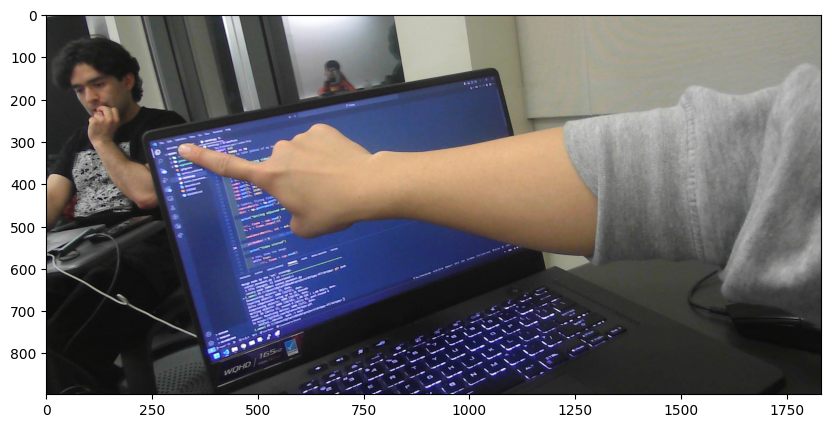

In [3]:
text_prompt = "screen"
image = 'images/0.jpg'

image = cv2.imread(image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

In [4]:
model = LangSAM(sam_type='vit_b')
image_pil = Image.fromarray(image)
masks, boxes, phrases, logits = model.predict(image_pil, text_prompt)

c:\Users\aaaab\.conda\envs\merced\lib\site-packages\torch\functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased
Model loaded from C:\Users\aaaab\.cache\huggingface\hub\models--ShilongLiu--GroundingDINO\snapshots\a94c9b567a2a374598f05c584e96798a170c56fb\groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


c:\Users\aaaab\.conda\envs\merced\lib\site-packages\transformers\modeling_utils.py:962: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
c:\Users\aaaab\.conda\envs\merced\lib\site-packages\torch\utils\checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
c:\Users\aaaab\.conda\envs\merced\lib\site-packages\torch\utils\checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


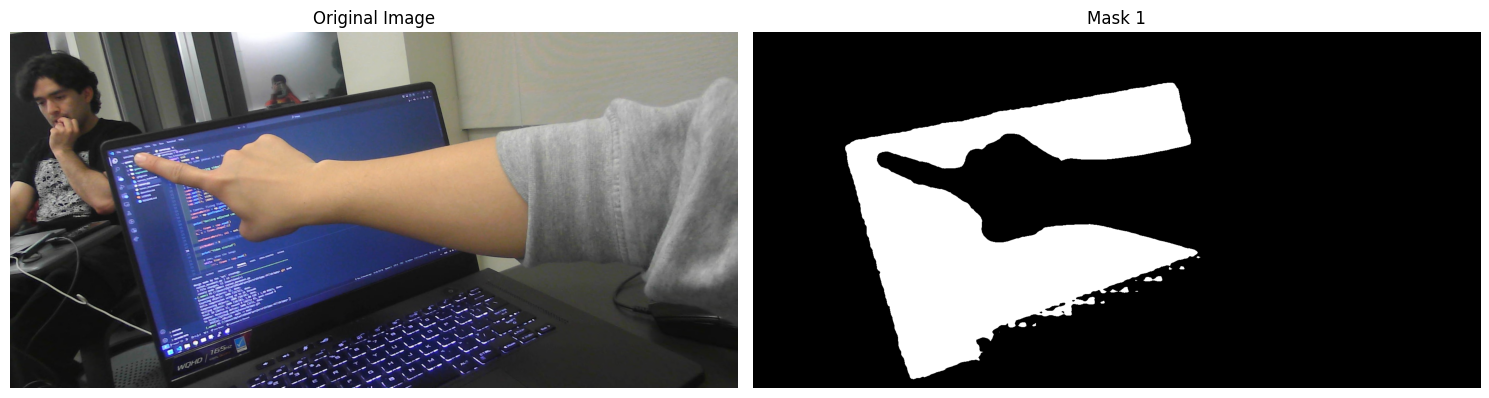

In [5]:
masks_np = [mask.squeeze().cpu().numpy() for mask in masks]
display_image_with_masks(image_pil, masks_np)

In [44]:
import cv2
import numpy as np

def draw_rotated_box(image, center, width, height, angle, color=(0, 255, 0), thickness=2):
    """
    Draws a rotated rectangle (bounding box) on the image.

    Parameters:
    - image: The image on which to draw, as a numpy array.
    - center: The center of the rectangle (x, y).
    - width: The width of the rectangle.
    - height: The height of the rectangle.
    - angle: The rotation angle of the rectangle, in degrees.
    - color: The color of the rectangle, as a tuple (B, G, R).
    - thickness: The thickness of the lines that make up the rectangle.
    """
    # Convert center from float to int to avoid OpenCV drawing errors
    center = tuple(map(int, center))
    
    # Calculate the rectangle's corner points
    rect = ((center[0], center[1]), (width, height), angle)
    box = cv2.boxPoints(rect)
    box = np.int0(box)  # Convert to integer
    
    # Draw the rectangle
    cv2.drawContours(image, [box], 0, color, thickness)
    
    return image


In [41]:
import numpy as np
from sklearn.decomposition import PCA

def fit_box_to_mask(mask):
    # Find the non-zero pixels in the mask
    points = np.argwhere(mask)

    # Calculate the mean of the points
    mean = np.mean(points, axis=0)

    # Subtract the mean from the points to center them
    centered_points = points - mean

    # Perform PCA to find the principal components
    pca = PCA(n_components=2)
    pca.fit(centered_points)

    # Get the eigenvectors and eigenvalues
    eigenvectors = pca.components_
    eigenvalues = pca.explained_variance_

    # Calculate the angle of rotation
    angle = np.arctan2(eigenvectors[0, 1], eigenvectors[0, 0])
    angle_degrees = np.degrees(angle)

    # Rotate the points to align with the principal components
    rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)],
                                [np.sin(angle), np.cos(angle)]])
    rotated_points = np.dot(centered_points, rotation_matrix)

    # Find the minimum and maximum coordinates of the rotated points
    min_coords = np.min(rotated_points, axis=0)
    max_coords = np.max(rotated_points, axis=0)

    # Calculate the width and height of the bounding box
    width = max_coords[0] - min_coords[0]
    height = max_coords[1] - min_coords[1]

    # Calculate the center of the bounding box
    center = (min_coords + max_coords) / 2

    # Rotate the center point back to the original coordinate system
    center = np.dot(center, rotation_matrix.T) + mean

    return center, width, height, angle_degrees

Center: [426.68488202 686.47309703], Width: 943.0748630090939, Height: 688.7494550890892, Angle: 119.39457775150717


C:\Users\aaaab\AppData\Local\Temp\ipykernel_33764\705435914.py:23: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)  # Convert to integer


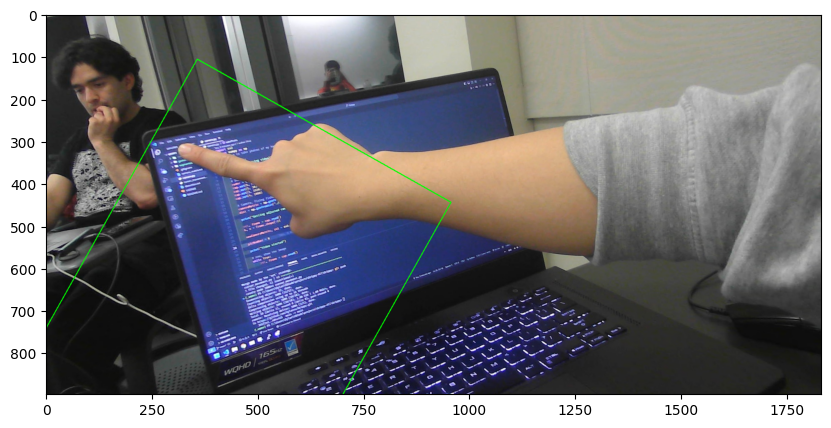

In [47]:
# Calculate the best-fit quadrilateral
center, width, height, angle = fit_box_to_mask(masks_np[0])
print(f"Center: {center}, Width: {width}, Height: {height}, Angle: {angle}")
# Draw the rotated bounding box on the image
image_np = np.array(image_pil)
output_image = draw_rotated_box(image_np, center, width, height, angle)

# Display the output image using plt
plt.figure(figsize=(10, 10))
plt.imshow(output_image)
plt.axis('on')
plt.show()